In [1]:
# import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler

In [2]:
# load data
df = pd.read_csv('Pokemon.csv')

In [3]:
# initial data exploration
df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


In [5]:
df.describe()

,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,362.813750,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,208.343798,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,1.000000,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,184.750000,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,364.500000,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,539.250000,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,721.000000,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


In [6]:
df.isnull().sum()

#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

In [7]:
# fix missing values
df['Type 2_missing'] = df['Type 2'].isnull()
df['Type 2'].fillna('Missing', inplace=True)

In [8]:
# recheck missing values
df.isnull().sum()

#                 0
Name              0
Type 1            0
Type 2            0
Total             0
HP                0
Attack            0
Defense           0
Sp. Atk           0
Sp. Def           0
Speed             0
Generation        0
Legendary         0
Type 2_missing    0
dtype: int64

In [9]:
# unique values
unique_counts = df.nunique()
print(unique_counts)

#                 721
Name              800
Type 1             18
Type 2             19
Total             200
HP                 94
Attack            111
Defense           103
Sp. Atk           105
Sp. Def            92
Speed             108
Generation          6
Legendary           2
Type 2_missing      2
dtype: int64


In [10]:
# 1-hot encoding
df = pd.get_dummies(df, columns=['Type 1', 'Type 2'])

In [11]:
# select numerical columns
numerical_cols = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']

In [12]:
# standardization
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [13]:
# outlier winsorizing
means = df[numerical_cols].mean()
stds = df[numerical_cols].std()


for col in numerical_cols:
    upper_limit = means[col] + 3 * stds[col]
    lower_limit = means[col] - 3 * stds[col]
    df[col] = np.where(df[col] > upper_limit, upper_limit, df[col])
    df[col] = np.where(df[col] < lower_limit, lower_limit, df[col])

### <em>**DIMENSION REDUCTION**</em>

C:\Users\48796\AppData\Local\Temp\ipykernel_30644\2437781768.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df.corr(method='pearson')


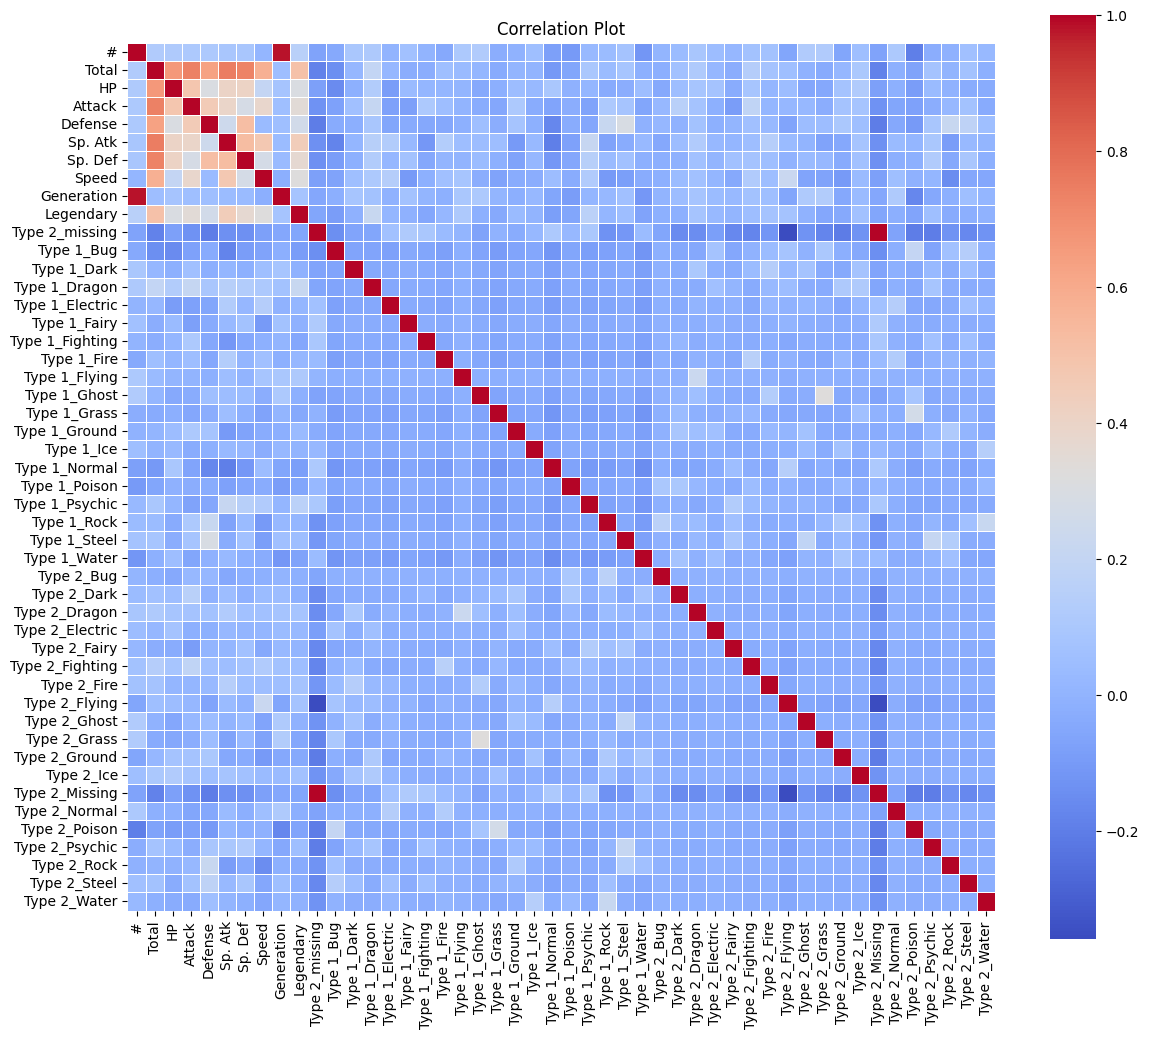

In [18]:
#visualization of correlations
plt.figure(figsize=(14, 12))
df_corr = df.corr(method='pearson')

sns.heatmap(df_corr, cmap='coolwarm', cbar=True, square=True, linewidths=0.5)
plt.title('Correlation Plot')
plt.show()